## Imports

In [1]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt

# Data

In [2]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('new_Exam_Score_Prediction.csv')

y = data['exam_score']
X = data.drop('exam_score', axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

x_train

,study_hours,class_attendance,facility_rating,gender,coaching,self_study
1156,5.57,43.4,2,1,0,1
1536,3.52,61.1,2,0,1,0
5035,1.83,58.6,1,0,0,0
9040,7.17,44.1,1,1,1,0
7272,5.06,86.1,2,1,1,0
...,...,...,...,...,...,...
11964,0.39,58.0,0,1,0,0
5191,2.44,74.7,2,0,0,1
5390,0.90,92.3,2,0,0,0
860,7.51,72.8,2,1,1,0


# Models

In [3]:
PATH = 'pipes'
pipe_names = os.listdir(PATH)[:-1] #Gitignore file to not pushing the models
pipe_names = [n.strip('.pkl') for n in pipe_names]

pipes = {}

for name in pipe_names:
    with open(os.path.join(PATH, name + '.pkl'), 'rb') as f:
        pipes[name] = pickle.load(f)

pipes

{'XSB': Pipeline(steps=[('sclaer', StandardScaler()),
                 ('regressor',
                  XGBRegressor(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.688748665879832, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.009078562712832831, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3, max_leaves=None,
                               min_child_weight=3, miss

# Friedman test

## Results for testing
Bootstrap

In [4]:
import numpy as np
from sklearn.metrics import r2_score

results = {n: [] for n in pipe_names}

idx = np.arange(0, x_train.shape[0])
for i in range(10):
    print("Iteration:", i+1)
    Boot_idx = np.random.choice(idx, size=int(10e3), replace=True, p=None)
    x_boot, y_boot = x_train.iloc[Boot_idx], y_train.iloc[Boot_idx]
    for p_idx, model in enumerate(pipes.values()):

        model.fit(x_boot, y_boot)
        preds = model.predict(x_test)
        score = r2_score(y_test, preds)

        results[pipe_names[p_idx]].append(score)


results_df = pd.DataFrame.from_dict(results, orient='index')
results_df

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


,0,1,2,3,4,5,6,7,8,9
XSB,0.652437,0.652705,0.654086,0.654460,0.656018,0.654196,0.654649,0.655681,0.652262,0.651204
Tree,0.605283,0.597975,0.605903,0.596262,0.596729,0.593755,0.607518,0.597241,0.597921,0.599876
SVR,0.651015,0.654028,0.655101,0.651958,0.651851,0.653319,0.653292,0.655423,0.650686,0.653271
Forest,0.637371,0.636351,0.642190,0.638531,0.640174,0.639252,0.643222,0.638963,0.637388,0.637528
Linear,0.658362,0.658455,0.658526,0.657705,0.658540,0.658245,0.658210,0.658672,0.657231,0.657815


# Friedman Test

In [5]:
from scipy.stats import friedmanchisquare

# Extract the lists from the dictionary
model_results = [results[i] for i in results]

# Run the test
stat, p = friedmanchisquare(*model_results)

print(stat)
print(f"P-value: {p}")

38.31999999999999
P-value: 9.625166581140252e-08


# Nemenyi Test
We need perform another test as the p-value in fridman test is low enough to reject null hypothesis

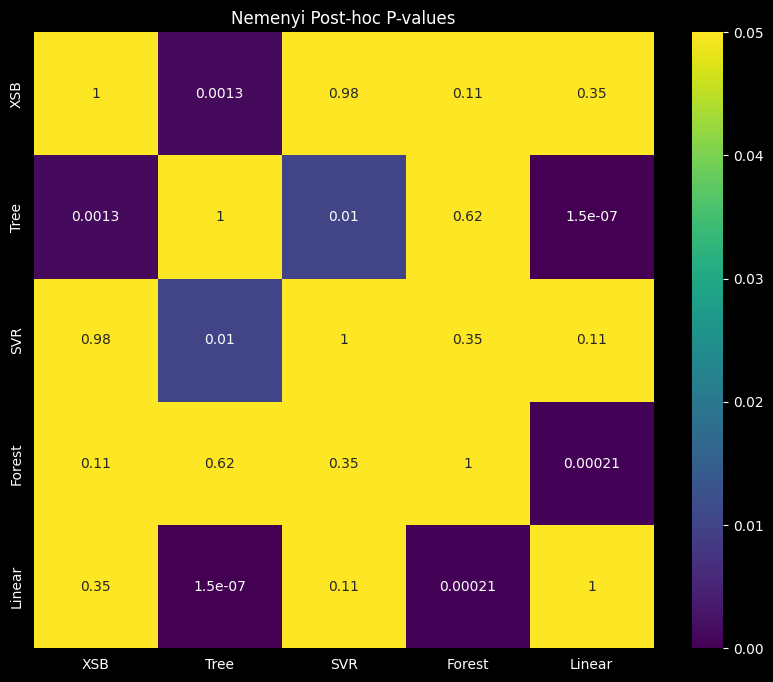

In [6]:
import scikit_posthocs as sp
import seaborn as sns

nemenyi_results = sp.posthoc_nemenyi_friedman(results_df.T)

plt.figure(figsize=(10, 8))
sns.heatmap(nemenyi_results, annot=True, cmap='viridis', vmin=0, vmax=0.05)
plt.title("Nemenyi Post-hoc P-values")
plt.show()

# Means of Model Results

In [7]:
results_df.mean(axis=1)

XSB       0.653770
Tree      0.599846
SVR       0.652994
Forest    0.639097
Linear    0.658176
dtype: float64